### Predicting Airbnb Listing Prices in Melbourne

In [1]:
# to prevent sklearn module not found error when import missforest
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from missingpy import MissForest
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC

# setting display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

---

## Problem Description and Initial Data Analysis


In [2]:
# read in data
trainpath = "train.csv"
df_train = pd.read_csv(trainpath, index_col='ID')

testpath = "test.csv"
df_test = pd.read_csv(testpath, index_col='ID')

# concatenate dataframes to reduce redundancies in operations
df = pd.concat([df_train, df_test])

#df.head()
df.to_csv("df_1.csv")

### Forecasting Problem

Airbnb is an online marketplace that connects people who want to rent out their homes with people who are looking for accommodations in specific locations.
<br><br>
The goal of this problem is to develop a model that can accurately predict the listed prices of Airbnb properties in Melbourne based on various characteristics. The dataset provided contains information about different Airbnb properties, including features such as the property type, number of bathrooms, number of bedrooms and beds, minimum and maximum nights of stay, and availability.
<br><br>
By leveraging the characteristics in the dataset and building a model, the objective is to learn the relationship between these features and the listed prices. The model will be trained to predict the price of a property based on its specific characteristics.

The steps involved in developing the model are as follows:

**Exploratory Data Analysis**
- The dataset will be analysed to understand the distribution of features and identify potential relationships between the features and the listed prices.

**Data Preprocessing**
- Missing values in the dataset will be identified and either removed or imputed. Categorical variables will be encoded using techniques such as one-hot encoding, and numerical features may be scaled if required.

**Feature Selection and Engineering**
- Relevant features that have a significant impact on price prediction will be selected. Additionally, new features may be created through feature engineering techniques, such as extracting information from existing features or combining multiple features.

**Model Selection**
- Regression models such as Linear Regression and GradientBoostingRegressor will be considered for training. These models will be trained on the preprocessed dataset and their performance will be evaluated using root mean squared error (RMSE) and cross-validation scores.

**Model Tuning**
- Hyperparameter tuning will be performed using techniques like GridSearchCV to find the best set of hyperparameters for each model in order to optimize the models' performance.

**Model Evaluation**
- The models will be evaluated to assess their performance in predicting the listed prices of Airbnb properties.

By developing a robust model, we will be able to accurately predict the listed prices of Airbnb properties in Melbourne. This model can provide valuable insights for both hosts and guests, enabling them to make more informed decisions about pricing and choosing suitable accommodation options.

### Evaluation Criteria
The criteria to assess prediction performance is RMSE. This performance metric measures the average distance between predictions obtained by a model and actual target values. Thus, the lower the distance (and the smaller RMSE), the better the prediction quality. It also has the advantage of being in the same unit as the predicted variable which makes it easy to interpret.

### Variables / Features

The data consists of 60 columns, 27 of type object, 18 of type float64 and 15 of type int64 types.
<br>
<br>
The variables types were classified into the following data types, 21 nominal, 12 ordinal and 27 numeric.


### Data Summary and Main Characteristics

Evaluation of the prices suggest that the distribution of prices is skewed with the range of prices between <b>25</b> and <b>145160</b> with a mean of <b>285.65</b>.

Prices appear to be sensitive to property type, with <b>Private room in villa</b> having the highest mean price of <b>2358.36</b> by <b>property type</b>, which is much higher than the mean prices of other property types, suggesting that the distribution of prices for this property type may be highly skewed. <b>Private room in bungalow</b> has the lowest mean price of <b>64.11</b>. 

<b>Entire rental unit</b> have the highest listings <b>2984</b>, and a mean price of <b>296.87</b>, which is close to the overall mean price, while <b>Shared room in guesthouse</b> has the least listings <b>2</b>, and a mean price of <b>67.00</b>.

<b>Boroondara</b> has the highest mean price of <b>894.95</b> by <b>neighbourhood_cleansed</b> and <b>Greater Dandenong</b> has the lowest mean price of <b>115.41</b>. Prices also seem sensitive to neighbourhood_cleansed. <b>Melbourne</b> has the highest listing of <b>2062</b>, and mean price of <b>335.35</b>, and <b>Greater Dandenong</b> has the lowest lisitngs of<b>32</b>.

<b>Instant bookable</b> properties have a slighly higher mean price <b>298.96</b> compared with those that are not instant bookable <b>281.34</b>.

<b>Entire home/apt</b> have the highest listing <b>by room type</b> with a mean price of <b>312.19</b>. <b>Hotel room</b> and <b>Shared room</b> have the least lisitings with a combined total of <b>80</b>.

Prices increase as the number of <b>accomodates</b> increases from 1 to 16, ranging from a mean of <b>81.65</b> to <b>724.04</b>. 

### Missing Observation

There are 24202 missing values across 29 variables, spread fairly evenly between the train and data sets.


---

## Data Cleaning, Missing Observations and Feature Engineering

In [3]:
##  Data Cleaning

#Functions
def replace_string(df, c, s, r='', f='strip'):
    if f == 'find_replace':
        mask = (df[c].notnull()) & (df[c].astype(str).str.contains(s))
        df.loc[mask, c] = df.loc[mask, c].astype(str).str.replace(s, r)
    if f == 'replace':
        df[c] = df[c].replace(s, r)
    elif f == 'strip':
        df[c] = df[c].dropna().astype(str).str.replace(s, r, regex=True)
    return df

def replace_numeric(df, c, n, r=0, f='match'):
    if f == 'isgreater':
        df.loc[df[c] > n, c] = r
    elif f == 'isless':
        df.loc[df[c] < n, c] = r
    elif f == 'match':
        df.loc[df[c] == n, c] = r
    return df

def convert_numeric(df, c, t, d=1):
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].astype(t)
    df[c] = df[c] / d
    return df

df2 = df


# price
df2 = replace_string(df2, 'price', '$','', 'strip')
df2 = replace_string(df2, 'price', ',','', 'strip')
df2 = convert_numeric(df2, 'price', 'float', 1)

# host_response_rate
df2 = replace_string(df2, 'host_response_rate', '%','', 'strip')
df2 = convert_numeric(df2, 'host_response_rate', 'float', 100)

# host_acceptance_rate
df2 = replace_string(df2, 'host_acceptance_rate', '%','', 'strip')
df2 = convert_numeric(df2, 'host_acceptance_rate', 'float', 100)

# bathrooms
df2 = replace_string(df2, 'bathrooms', 'Half-bath','0.5', 'find_replace')
df2 = replace_string(df2, 'bathrooms', 'half-bath','0.5', 'find_replace')
df2 = replace_string(df2, 'bathrooms', '[^0-9\.]','', 'strip')
df2 = convert_numeric(df2, 'bathrooms', 'float', 1)

# max/min nights - replace extreme values
df2 = replace_numeric(df2, 'maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'minimum_maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'maximum_maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'minimum_nights_avg_ntm', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'maximum_nights_avg_ntm', 9000, 1000, 'isgreater')

df2.to_csv("df_2.csv")

#### Price
The target variable price was converted from a string containing the $ sign to a numeric float variable.
<br>
    
#### host_response_rate and host_acceptance_rate
host_response_rate and host_acceptance_rate variables were converted from strings containing the % sign to a numeric float variable.
<br>

#### bathrooms
Some records for bathrooms were 'Half-bath' and 'half-bath', that is they did not contain any numeric characters. These were converted to the string '0.5'. For the remaining records non-numeric characters were removed and then the whole column was converted to a numeric float variable.
<br>

#### maximum_nights, minimum_maximum_nights,maximum_maximum_nights and maximum_nights_avg_ntm
maximum_nights, minimum_maximum_nights, maximum_maximum_nights and maximum_nights_avg_ntm had some extreme values, which appear to be errors - these were replaced with 1000 which appears to be the threshold based on other min/max nights variables.

In [4]:
## Feature Engineering

df3 = df2

# Create new features email, phone and work_email from host_verifications
df3 = replace_string(df3, 'host_verifications', "['email']","'1','0','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['phone']","'0','1','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['email', 'phone']","'1','1','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['phone', 'work_email']","'0','1','1'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['email', 'phone', 'work_email']","'1','1','1'", 'replace')

df3[['email', 'phone', 'work_email']] = df3['host_verifications'].str.split(',', expand=True)

df3 = replace_string(df3, 'email', "'",'', 'strip')
df3 = convert_numeric(df3, 'email','int', 1)

df3 = replace_string(df3, 'phone', "'",'', 'strip')
df3 = convert_numeric(df3, 'phone','int', 1)

df3 = replace_string(df3, 'work_email', "'",'', 'strip')
df3 = convert_numeric(df3, 'work_email','int', 1)

df3.drop(['host_verifications'], axis=1, inplace=True)

In [5]:
# Create new features smoke_alarm, kitchen, essential, hangers, wifi from amenities
# These are the top 5 ammenities in the dataset

from collections import Counter

amenity_count = Counter()
amenity_count_total = Counter()
count_total = []

for amenities_str in df3['amenities']:
    amenity_count_total = 0
    amenities_list = amenities_str.strip('][').replace('"', '').split(', ')
    for amenity in amenities_list:
        amenity_count[amenity] += 1
        amenity_count_total  += 1
    count_total.append(amenity_count_total)

df_amenities = pd.DataFrame(columns=[ 'amenity_count'])
df_amenities['amenity_count'] = amenity_count
df_amenities = df_amenities.sort_values('amenity_count', ascending=False)
df_amenities.head(5)

#df_acc = pd.DataFrame(columns=[ 'total_amenity_counts'])
#df_acc['total_amenity_counts'] = count_total
#df_acc
#print(acc)

#Smoke alarm	9548
#Kitchen	9383
#Essentials	9327
#Hangers	8702
#Wifi	8618

df3['amenity_count'] = count_total

df3[['smoke_alarm','kitchen','essentials','hangers','wifi']] = 0

for idx, amenities_str in df3['amenities'].items():
    amenities_list = amenities_str.strip('][').replace('"', '').split(', ')
    if 'Smoke alarm' in amenities_list:
        df3.loc[idx, 'smoke_alarm'] = 1
    if 'Kitchen' in amenities_list:
        df3.loc[idx, 'kitchen'] = 1        
    if 'Essentials' in amenities_list:
        df3.loc[idx, 'essentials'] = 1      
    if 'Hangers' in amenities_list:
        df3.loc[idx, 'hangers'] = 1      
    if 'Wifi' in amenities_list:
        df3.loc[idx, 'wifi'] = 1              


df3.drop(['amenities'], axis=1, inplace=True)

df3.to_csv("df_3.csv")

#### Neighbourhood Groups based on mean neighbourhood price

In [6]:
# Group neighbourhoods into low, medium, high based on average price
df3.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False)

neighbourhood_cleansed
Boroondara           894.947712
Yarra                353.306695
Yarra Ranges         349.385484
Knox                 336.793651
Melbourne            335.346266
Bayside              325.077519
Kingston             265.690722
Port Phillip         263.867609
Cardinia             244.456790
Nillumbik            241.120000
Manningham           224.040000
Stonnington          214.961187
Moonee Valley        208.488636
Hobsons Bay          200.314286
Glen Eira            199.652778
Melton               198.325581
Frankston            198.207921
Hume                 194.348485
Wyndham              194.119760
Whitehorse           191.851852
Maroondah            183.270270
Whittlesea           179.805556
Brimbank             165.966667
Banyule              165.911392
Maribyrnong          163.893617
Monash               160.780347
Darebin              158.417219
Casey                150.600000
Moreland             144.171053
Greater Dandenong    115.406250
Name: price, dtyp

Mean price values per suburb are skewed due to outliers. Hence categorisation must be conducted based on data without outliers.

In [7]:
def get_outliers(data, threshold=3):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    z_scores = scaled_data.flatten()
    outlier_locations = np.where(np.abs(z_scores) > threshold)[0]
    outlier_values = data[outlier_locations]
    outlier_df = pd.DataFrame({'Outlier': outlier_values})
    return outlier_df

In [8]:
# Remove price outliers
price_outlier = get_outliers(df3['price'], threshold=3)
no_out = df3[~df3['price'].isin(price_outlier['Outlier'].values)]
no_out.reset_index(drop=True, inplace=True)

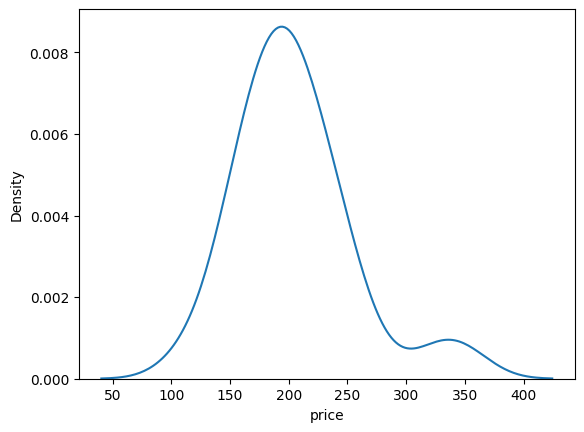

In [9]:
# check prices again
suburb_prices = no_out.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False).reset_index()
sns.kdeplot(data=suburb_prices, x='price');

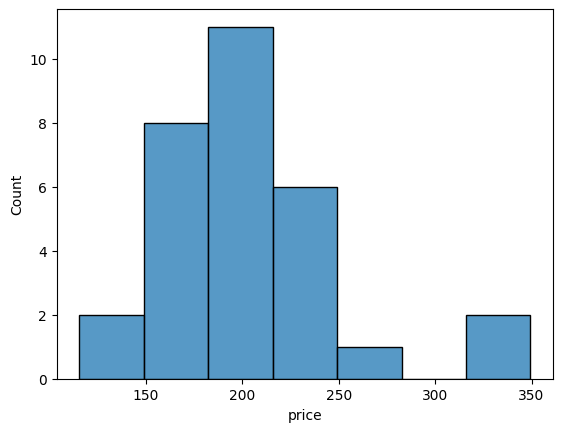

In [10]:
sns.histplot(data=suburb_prices, x='price');

It looks like the suburbs could be split into high and normal prices.

In [12]:
# group suburbs based on quartiles

# Define the labels for the price groups
labels = ['low_price', 'medium_price', 'high_price']

# Categorize the suburbs based on mean prices
suburb_prices['suburb_prices'] = pd.qcut(suburb_prices.price, q=[0, 0.25, 0.75, 1], labels=labels)

suburb_prices

,neighbourhood_cleansed,price,suburb_prices
0,Yarra Ranges,349.385484,high_price
1,Bayside,325.077519,high_price
2,Kingston,265.690722,high_price
3,Cardinia,244.456790,high_price
4,Nillumbik,241.120000,high_price
5,Port Phillip,241.056628,high_price
6,Yarra,234.116883,high_price
7,Melbourne,228.756928,high_price
8,Manningham,224.040000,medium_price
9,Stonnington,214.961187,medium_price


In [13]:
# merge groups back into original df
df3 = df3.merge(suburb_prices[['neighbourhood_cleansed', 'suburb_prices']],on='neighbourhood_cleansed', how='left')

#### Convert Availability into high, medium, low

In [14]:
df3.availability_30.value_counts(dropna=False, normalize=True).reset_index().sort_values("index")

,index,availability_30
0,0,0.2379
2,1,0.0369
6,2,0.0344
12,3,0.0287
10,4,0.0331
7,5,0.0343
5,6,0.0345
4,7,0.0350
3,8,0.0359
1,9,0.0391


Rule set:
- < 5 days = high demand
- \>= 5 days & < 15 days = medium demand
- \>= 15 days = low demand

In [15]:
# Define the demand categories
demand_categories = ['high_demand', 'medium_demand', 'low_demand']

# Apply the logic using list comprehension
df3['demand_level'] = ['high_demand' if x < 5 else 'medium_demand' if x < 15 else 'low_demand' for x in df3.availability_30]

#### More Feature Engineering

#### Re-weighting Review Scores
`review scores` should be higher weighted if these resulted from more reviews as this would be more accurate. We could first account for different timeframes by subtracting first_review from today_date and divide number_of_reviews by this difference to get the amount of reviews per day (could also do month by dividing by 30 to have smaller numbers) since the first review was made. This could then be multiplied by the review_scores to give them more weight if there were more number of reviews per day. Actually, there is the feature reviews_per_month which calculates the difference between first review and today. Hence we can use this to multiply. Doing so might have the following effects:
- we would penalise old listings that haven't been reviewed in a long time (there are some which had their last review in 2012, so their reviews might not be accurate anymore and should get less weight)

Based on feature importance from initial XGBoost models, we will scale `review_scores_location`, `review_scores_rating`, and `review_scores_value`.

In [16]:
columns = ['review_scores_rating', 'review_scores_location', 'review_scores_value']

for f in columns:
    if f in df3.columns:
        new_column = f + "_scaled"
        df3[new_column] = df3[f] * df3.reviews_per_month
        #df3.drop(columns=[f], inplace=True)

df3

,source,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,suburb_prices,demand_level,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled
0,city scrape,"The Stables, Richmond",Superbly located hotel style accommodation in ...,Richmond is a great neighbourhood. A beautifu...,Ione,2013-03-16,"Melbourne, Australia",I'm a working mum who loves being able to shar...,within an hour,1.00,0.98,f,Richmond,2.0,t,t,"Richmond, Victoria, Australia",Yarra,-37.82030,144.99016,Entire guesthouse,Entire home/apt,2,1.0,1.0,1.0,2,14,2.0,2,1125,1125.0,2.0,1125.0,t,0,0,0,12.0,741,37,1,2013-03-29,2023-02-18,4.88,4.91,4.97,4.94,4.93,4.93,4.82,f,2,2,0,0,6.11,132.0,1.0,1.0,0.0,38,1,0,1,1,1,high_price,high_demand,29.8168,30.1223,29.4502
1,city scrape,Room in Cool Deco Apartment in Brunswick East,A large air conditioned room with firm queen s...,This hip area is a crossroads between two grea...,Lindsay,2009-09-16,"Melbourne, Australia",As an artist working in animation and video I ...,within a few hours,1.00,0.98,f,Brunswick,1.0,t,t,"Brunswick East, Victoria, Australia",Moreland,-37.76606,144.97951,Private room in rental unit,Private room,2,1.0,1.0,1.0,4,27,4.0,4,27,27.0,4.0,27.0,t,0,12,22,112.0,169,25,3,2013-01-12,2023-03-08,4.48,4.64,3.97,4.72,4.69,4.65,4.60,f,1,0,1,0,1.37,39.0,1.0,1.0,0.0,57,1,1,1,1,0,low_price,high_demand,6.1376,6.3705,6.3020
2,city scrape,The Suite @ Angelus Retreat,<b>The space</b><br />Welcome to ANGELUS Retre...,NaN,Margaret Jiin,2011-11-28,"Melbourne, Australia",I have very special interests in Life and Life...,within a few hours,1.00,0.78,t,NaN,2.0,t,t,NaN,Yarra Ranges,-37.90546,145.39447,Entire rental unit,Entire home/apt,4,2.5,2.0,4.0,2,365,2.0,2,365,365.0,2.0,365.0,t,30,60,90,365.0,8,2,0,2015-07-06,2022-06-13,4.75,4.88,4.75,4.88,4.50,5.00,4.75,f,2,2,0,0,0.09,270.0,1.0,1.0,0.0,21,1,1,0,0,1,high_price,low_demand,0.4275,0.4500,0.4275
3,city scrape,Million Dollar Views Over Melbourne,<b>The space</b><br /><b>Enjoy Million Dollar ...,NaN,Paul,2010-06-13,"Melbourne, Australia",Professional couple who enjoy entertaining in ...,within a day,0.75,0.92,f,Southbank,4.0,t,t,NaN,Melbourne,-37.82163,144.96672,Private room in rental unit,Private room,2,2.5,1.0,1.0,1,730,1.0,1,730,730.0,1.0,730.0,t,30,60,90,365.0,2,0,0,2011-10-16,2012-01-27,4.50,4.00,4.50,4.00,4.00,5.00,4.00,f,1,0,1,0,0.01,1000.0,1.0,1.0,0.0,13,0,1,0,0,1,high_price,low_demand,0.0450,0.0500,0.0400
4,city scrape,Melbourne - Old Trafford Apartment,After hosting many guests from all over the wo...,Our street is quiet & secluded but within walk...,Daryl & Dee,2010-07-12,"Berwick, Australia",We are an active couple who work from home and...,within a few hours,1.00,0.87,t,NaN,1.0,t,t,"Berwick, Victoria, Australia",NaN,-38.05725,145.33936,Entire rental unit,Entire home/apt,5,1.0,3.0,3.0,1,14,1.0,1,14,14.0,1.0,14.0,t,17,21,51,312.0,214,39,4,2010-11-24,2023-03-03,4.86,4.91,4

Allow us to capture information on multiple features as a ratio, thereby also reducing dimensionality of the data. We will create the following new features:
- bathrooms/bedrooms: larger ratio would indicate more comfort --> should equal higher price
- bathrooms/accommodates: larger ratio would indicate more comfort --> should equal higher price
- bedrooms/accommodates : larger ratio would indicate more comfort --> should equal higher price
- beds/accommodates : larger ratio would indicate more comfort --> should equal higher price
- bedrooms/beds: larger ratio would indicate low comfort --> should equal lower price
- maximum_nights/minimum_nights not sure if relevant, but we could analyse. both of these variables were deemed relevant in my XGBoost model (this also is feature selection since we capture both variables at once).
- availability_365 /365: gives a ratio of how booked out the place is over the next year --> lower ratio would indicate high demand  --> should equal higher price

#### Bathrooms / Bedrooms

In [17]:
df3['bath_bed_ratio'] = df3.bathrooms / df3.bedrooms

#### Bathrooms / Accommodates

In [18]:
df3['bath_guests_ratio'] = df3.bathrooms / df3.accommodates

#### Bedrooms / Accommodates

In [19]:
df3['bedrooms_guests_ratio'] = df3.bedrooms / df3.accommodates

#### Beds / Accommodates

In [20]:
df3['beds_guests_ratio'] = df3.beds / df3.accommodates

#### Bedrooms / Beds

In [21]:
df3['bedrooms_beds_ratio'] = df3.bedrooms / df3.beds

#### Maximum Nights / Minimum Nights

In [22]:
df3['maxnights_minnights_ratio'] = df3.maximum_nights / df3.minimum_nights

### New Features

#### host_verifications  
Created new binary numeric features 'email', 'phone', 'work_email from 'host_verifications' and deleted the column 'host_verifications'
<br>
    
#### amenities
Create new binary numeric features 'smoke_alarm', 'kitchen', 'essential', 'hangers', 'wifi' from 'amenities' which are the top 5 amenities in the dataset and deleted the column 'amenities'.
<br>

#### host_verifications
Created new binary numeric features 'email', 'phone', 'work_email from 'host_verifications' and deleted the column 'host_verifications'
<br>
    
#### amenities
Create new binary numeric features 'smoke_alarm', 'kitchen', 'essential', 'hangers', 'wifi' from 'amenities' which are the top 5 amenities in the dataset and deleted the column 'amenities'.
<br>
    
#### Neighbourhood prices
Create new categorical feature `suburb_prices` with 'low_price', 'medium_price', 'high_price' according to the average listing price in the suburb ranked by quartiles.
<br>
    
#### Availability_30  
Create new categorical feature `demand_level` with 'low_demand', 'medium_demand', 'high_demand' according to the days a listing is available in the next 30 days.
<br>

### Imputing missing values
Imputed missing values for all features except for 'description', 'neighborhood_overview', 'host_location' and 'host_about'.
 

#### Brute Force Missing Value Imputation

In [23]:
df4 = df3.copy()

from sklearn.impute import SimpleImputer

def impute_missing(df, c, s='most_frequent'):
    for col in c:
        i = SimpleImputer(missing_values = np.nan, strategy=s) 
        i = i.fit(df[[col]])
        df[[col]] = i.transform(df[[col]])
    return df

# host_location-> most_frequent
df4 = impute_missing(df4, ['host_location'], 'most_frequent')
df4 = df3.copy()

from sklearn.impute import SimpleImputer

def impute_missing(df, c, s='most_frequent'):
    for col in c:
        i = SimpleImputer(missing_values = np.nan, strategy=s) 
        i = i.fit(df[[col]])
        df[[col]] = i.transform(df[[col]])
    return df

# host_location and suburb_prices -> most_frequent
df4 = impute_missing(df4, ['host_location'
                           , 'suburb_prices'
                          ], 'most_frequent')

# host_response_time -> most_frequent
df4 = impute_missing(df4, ['host_response_time'], 'most_frequent')

# host_response_rate, host_acceptance_rate -> mean
df4 = impute_missing(df4, ['host_response_rate', 'host_acceptance_rate'], 'mean')

# host_is_superhost -> most_frequent
df4 = impute_missing(df4, ['host_is_superhost'], 'most_frequent')

# host_neighbourhood, neighbourhood, neighbourhood_cleansed -> most_frequent
df4 = impute_missing(df4, ['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed'], 'most_frequent')

# property_type, room_type -> most_frequent
df4 = impute_missing(df4, ['property_type', 'room_type'], 'most_frequent')

# bathrooms, bedrooms, beds, first_review -> median
df4 = impute_missing(df4, ['bathrooms','bedrooms','beds'], 'median')

# minimum_minimum_nights, maximum_maximum_nights -> median
df4 = impute_missing(df4, ['minimum_minimum_nights', 'maximum_maximum_nights'], 'median')

# availability_365 -> mean
df4 = impute_missing(df4, ['availability_365'], 'mean')

# first_review, last_review -> most_frequent
df4 = impute_missing(df4, ['first_review', 'last_review'], 'most_frequent')

#review_scores_accuracy, review_scores_checkin, review_scores_cleanliness, review_scores_communication, review_scores_location
# review_scores_rating, review_scores_value -> mean
df4 = impute_missing(df4, ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                           'review_scores_communication', 'review_scores_location','review_scores_value','review_scores_rating_scaled',
                           'review_scores_location_scaled', 'review_scores_value_scaled', 'bath_bed_ratio', 'bath_guests_ratio',
                           'bedrooms_guests_ratio', 'beds_guests_ratio', 'bedrooms_beds_ratio'
                          ], 'mean')
# reviews_per_month -> mean
df4 = impute_missing(df4, ['reviews_per_month'], 'mean')

# email, phone, work_email from -> most_frequent
df4 = impute_missing(df4, ['email', 'phone', 'work_email'], 'most_frequent')

# smoke_alarm, kitchen, essentials, hangers, wifi -> most_frequent
df4 = impute_missing(df4, ['smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi'], 'most_frequent')

df4.to_csv("df_4.csv")

### Encoding Categorical Variables

In [24]:
df5 = df4.copy()

# onehot encoder function
def onehot(df, c):
    for col in c:
        df = df.join(pd.get_dummies(df[[col]], drop_first=True))
        df.drop([col], axis=1, inplace=True)
    return df

# encode binary classifiers
# 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable'
df5 = onehot(df5, ['source', 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable','demand_level'
                  ])

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# encode source
#le = encoder.fit_transform(df5['source'].values)
#df5['source'] = le
#print('source:', encoder.classes_)

# encode room_type
le = encoder.fit_transform(df5['room_type'].values)
df5['room_type'] = le
room_type_classes = encoder.classes_


#encode top 5 property_type and other
top_5_property_type = df5['property_type'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_property_type + ['other'])  
#df5['property_type_encoded'] = df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df5['property_type'] = df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df5 = onehot(df5, ['property_type'])

#df5['property_type_encoded'] = encoder.transform(df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other'))
#df5.drop(['property_type'], axis=1, inplace=True)
#df5 = df5.rename(columns={'property_type_encoded': 'property_type'})
#property_type_classes = encoder.classes_


#encode top 5 neighbourhood_cleansed and other
top_5_neighbourhood_cleansed = df5['neighbourhood_cleansed'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_neighbourhood_cleansed + ['other'])  

df5['neighbourhood_cleansed'] = df5['neighbourhood_cleansed'].apply(lambda x: x if x in top_5_neighbourhood_cleansed else 'other')
df5 = onehot(df5, ['neighbourhood_cleansed'])

# encode neighbourhood price groups
df5 = onehot(df5, ['suburb_prices']) # alternatively ordinal

#df5['neighbourhood_cleansed_encoded'] = encoder.transform(df5['neighbourhood_cleansed'].apply(lambda x: x if x in top_5_neighbourhood_cleansed else 'other'))
#df5.drop(['neighbourhood_cleansed'], axis=1, inplace=True)
#df5 = df5.rename(columns={'neighbourhood_cleansed_encoded': 'neighbourhood_cleansed'})
#neighbourhood_cleansed_classes = encoder.classes_


# map/rank host_response_time
host_response_mapping = {'within an hour':1, 'within a few hours':2, 'within a day':3, 'a few days or more':4}
df5['host_response_time'] = df5['host_response_time'].map(host_response_mapping)

# convert host_since into days based on current date
from datetime import datetime
today = datetime.today()
df5['host_since'] = pd.to_datetime(df5['host_since'], format='%Y/%m/%d')
df5['host_since'] = (today - df5['host_since']).dt.days

# convert first_review into days based on current date
df5['first_review'] = pd.to_datetime(df5['first_review'], format='%Y/%m/%d')
df5['first_review'] = (today - df5['first_review']).dt.days

# convert last_review into days based on current date
df5['last_review'] = pd.to_datetime(df5['last_review'], format='%Y/%m/%d')
df5['last_review'] = (today - df5['last_review']).dt.days

df5.to_csv("df_5.csv")

#### ML Feature Imputation with MissForest Classifier
was tried as an alternative to brute force. However, it did not have a positive impact.

In [25]:
df_impute = df3.drop(['price'], axis=1)

In [26]:
# encode binary classifiers
# 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable'
df_impute = onehot(df_impute, ['source', 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable','demand_level'])

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# encode room_type
le = encoder.fit_transform(df_impute['room_type'].values)
df_impute['room_type'] = le
room_type_classes = encoder.classes_

#encode top 5 property_type and other
top_5_property_type = df_impute['property_type'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_property_type + ['other'])  
#df5['property_type_encoded'] = df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df_impute['property_type'] = df_impute['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df_impute = onehot(df_impute, ['property_type'])

#encode top 5 neighbourhood_cleansed and other
top_5_neighbourhood_cleansed = df_impute['neighbourhood_cleansed'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_neighbourhood_cleansed + ['other'])  

df_impute['neighbourhood_cleansed'] = df_impute['neighbourhood_cleansed'].apply(lambda x: x if x in top_5_neighbourhood_cleansed else 'other')
df_impute = onehot(df_impute, ['neighbourhood_cleansed'])

# encode neighbourhood price groups
df_impute = onehot(df_impute, ['suburb_prices']) # alternatively ordinal

# map/rank host_response_time
host_response_mapping = {'within an hour':1, 'within a few hours':2, 'within a day':3, 'a few days or more':4}
df_impute['host_response_time'] = df_impute['host_response_time'].map(host_response_mapping)

# convert host_since into days based on current date
from datetime import datetime
today = datetime.today()
df_impute['host_since'] = pd.to_datetime(df_impute['host_since'], format='%Y/%m/%d')
df_impute['host_since'] = (today - df_impute['host_since']).dt.days

# convert first_review into days based on current date
df_impute['first_review'] = pd.to_datetime(df_impute['first_review'], format='%Y/%m/%d')
df_impute['first_review'] = (today - df_impute['first_review']).dt.days

# convert last_review into days based on current date
df_impute['last_review'] = pd.to_datetime(df_impute['last_review'], format='%Y/%m/%d')
df_impute['last_review'] = (today - df_impute['last_review']).dt.days

In [27]:
df_impute.isnull().sum()

name                                               1
description                                       88
neighborhood_overview                           3247
host_name                                          0
host_since                                         0
host_location                                   2050
host_about                                      3711
host_response_time                               737
host_response_rate                               737
host_acceptance_rate                             721
host_neighbourhood                              5526
host_listings_count                                0
neighbourhood                                   3247
latitude                                           0
longitude                                          0
room_type                                          0
accommodates                                       0
bathrooms                                          6
bedrooms                                      

In [28]:
df_impute.columns

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
       'host_listings_count', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host

In [29]:
# drop irrelevant or text columns
df_impute = df_impute.drop(columns=['name', 'description', 'neighborhood_overview', 'host_name','host_location', 'host_about', 'host_neighbourhood', 
                                     'neighbourhood', 'source_previous scrape'])

In [30]:
%%capture --no-display
imputer = MissForest()
X_imputed = imputer.fit_transform(df_impute)

In [31]:
X_imputed = pd.DataFrame(X_imputed, columns = df_impute.columns)

In [32]:
X_imputed.isnull().sum()

host_since                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_listings_count                             0
latitude                                        0
longitude                                       0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0


In [33]:
X_imputed

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price
0,3730.0,1.00,1.0000,0.9800,2.0,-37.82030,144.99016,0.0,2.0,1.0,1.0,1.0,2.0,14.0,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3717.00,104.00,4.8800,4.9100,4.970,4.94,4.9300,4.9300,4.8200,2.0,2.0,0.0,0.0,6.1100,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,29.816800,30.122300,29.450200,1.000000,0.50000,0.500,0.50000,1.000000,7.00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,5007.0,2.00,1.0000,0.9800,1.0,-37.76606,144.97951,2.0,2.0,1.0,1.0,1.0,4.0,27.0,4.0,4.0,27.0,27.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3793.00,86.00,4.4800,4.6400,3.970,4.72,4.6900,4.6500,4.6000,1.0,0.0,1.0,0.0,1.3700,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,6.137600,6.370500,6.302000,1.000000,0.50000,0.500,0.50000,1.000000,6.75,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4204.0,2.00,1.0000,0.7800,2.0,-37.90546,145.39447,0.0,4.0,2.5,2.0,4.0,2.0,365.0,2.0,2.0,365.0,365.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2888.00,354.00,4.7500,4.8800,4.750,4.88,4.5000,5.0000,4.7500,2.0,2.0,0.0,0.0,0.0900,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,0.427500,0.450000,0.427500,1.250000,0.62500,0.500,1.00000,0.500000,182.50,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4737.0,3.00,0.7500,0.9200,4.0,-37.82163,144.96672,2.0,2.0,2.5,1.0,1.0,1.0,730.0,1.0,1.0,730.0,730.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4247.00,4144.00,4.5000,4.0000,4.500,4.00,4.0000,5.0000,4.0000,1.0,0.0,1.0,0.0,0.0100,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.045000,0.050000,0.040000,2.500000,1.25000,0.500,0.50000,1.000000,730.00,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4708.0,2.00,1.0000,0.8700,1.0,-38.05725,145.33936,0.0,5.0,1.0,3.0,3.0,1.0,14.0,1.0,1.0,14.0,14.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4573.00,91.00,4.8600,4.9100,4.980,4.91,4.9300,4.9000,4.8700,1.0,1.0,0.0,0.0,1.4300,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,6.949800,7.007000,6.964100,0.333333,0.20000,0.600,0.60000,1.000000,14.00,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [34]:
# add price back
X_imputed['price'] = df3.price

# create logarithmic price column
X_imputed['log_price'] = np.log(X_imputed['price'])

X_imputed.to_csv("missforest_imputed.csv")



* Encoded  binray classifications   
'source', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable' using onehot encoding.  

* Encoded 'room_type' using LabelEncoder.  
* Encoded 'property_type' and 'neighbourhood_cleansed' using LabelEncoder grouped by the top 5 classifications in each and the rese grouped as 'other'  
* Encoded and ranked host_response_time.



### Other Actions

In [35]:
import numpy as np

df6 = df5
df6['log_price'] = np.log(df6['price'])
   
columns_to_drop = ['name','description','neighborhood_overview',
                   'host_name','host_location','host_about', 'host_neighbourhood',
                   'neighbourhood','first_review','last_review',]

df6 = df6.drop(columns=columns_to_drop)

df6.to_csv("df_6.csv")


Added log_price to normalise price distribution.

#### Univariate EDA

In [36]:
df6.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_roo

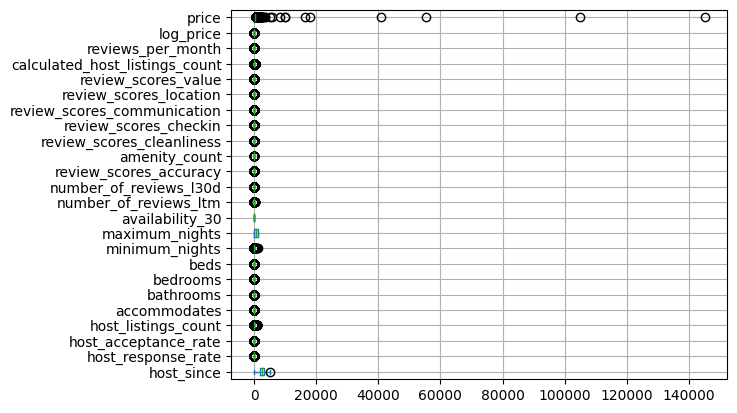

In [37]:
df6[['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', #'availability_60',
       #'availability_90', 'availability_365', 
     'review_scores_rating', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',  'amenity_count',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     'log_price', 'price']].plot.box(vert = False, grid = True);

price heavily influences the overall picture.

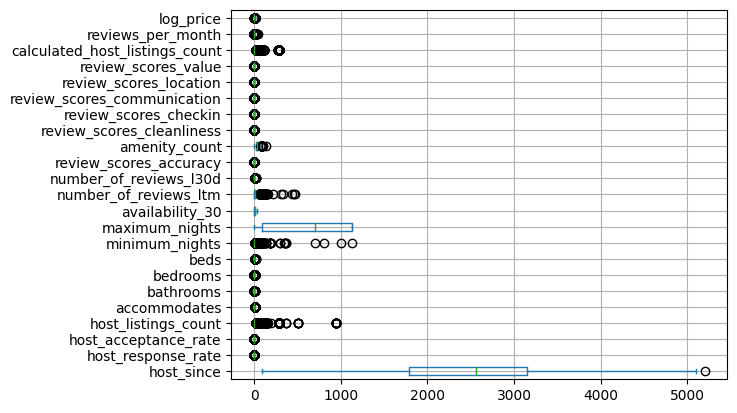

In [38]:
df6[['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', #'availability_60',
       #'availability_90', 'availability_365', 
     'review_scores_rating', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',  'amenity_count',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     'log_price']].plot.box(vert = False, grid = True);

Still a few distortions, let's look at the variables with large magnitude only.

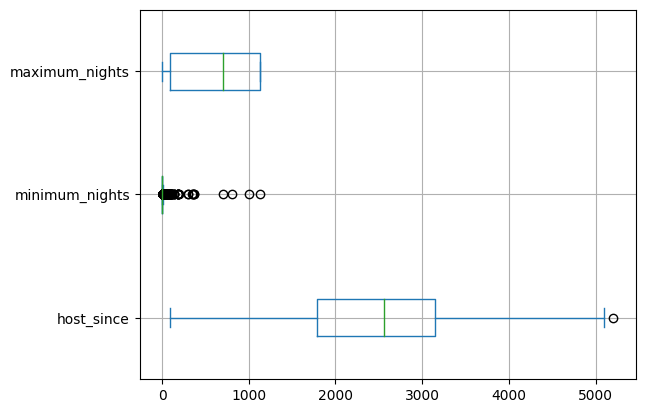

In [39]:
df6[['host_since', #'host_response_rate',
       #'host_acceptance_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
     'minimum_nights', 'maximum_nights', #'availability_30', 'availability_60',
       #'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price', 'amenity_count'
    ]].plot.box(vert = False, grid = True);

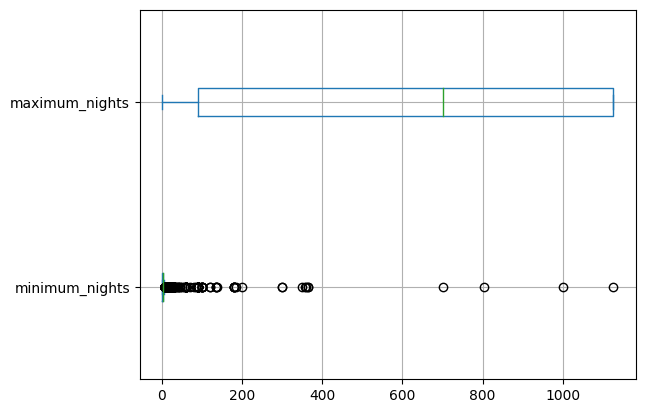

In [40]:
df6[[#'host_since', #'host_response_rate',
       #'host_acceptance_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
     'minimum_nights', 'maximum_nights', #'availability_30', 'availability_60',
       #'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price', 'amenity_count'
    ]].plot.box(vert = False, grid = True);

It is clear that there a few listings which have extremely large minimum nights restrictions. Let's have a look.

In [41]:
df6.loc[df6.minimum_nights > 150]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,source_previous scrape,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_low_price,suburb_prices_medium_price,log_price
104,3525,3,1.000000,0.710000,1.0,-37.86939,144.81845,0,3,1.0,2.0,2.0,180,250,180.0,180,250,250.0,180.0,250.0,0,17,47,168.580791,19,3,0,4.53,4.760000,4.470000,4.940000,4.88000,4.590000,4.590000,1,1,0,0,0.17,165.0,1.0,1.0,0.0,33,1,1,1,1,0,0.7701,0.78030,0.780300,0.500000,0.333333,0.666667,0.666667,1.00000,1.388889,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,5.105945
397,3522,2,0.800000,0.880000,4.0,-37.81458,144.94485,0,2,1.0,1.0,1.0,180,730,180.0,180,730,730.0,180.0,730.0,0,0,0,0.000000,18,0,0,4.33,4.940000,4.280000,4.440000,4.17000,4.890000,4.390000,1,1,0,0,0.17,200.0,1.0,1.0,0.0,21,1,1,1,0,0,0.7361,0.83130,0.746300,1.000000,0.500000,0.500000,0.500000,1.00000,4.055556,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5.298317
581,3014,3,1.000000,0.886732,1.0,-37.87231,144.98323,0,3,1.5,1.0,2.0,185,1125,185.0,185,1125,1125.0,185.0,1125.0,29,59,89,361.000000,166,0,0,4.95,4.960000,4.890000,4.960000,4.98000,4.950000,4.900000,1,1,0,0,1.71,85.0,1.0,1.0,1.0,38,1,1,1,1,1,8.4645,8.46450,8.379000,1.500000,0.500000,0.333333,0.666667,0.50000,6.081081,0,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,4.442651
860,2802,1,1.000000,0.770000,5.0,-37.94957,145.04722,0,4,2.0,2.0,2.0,180,1125,2.0,2,99,1000.0,2.0,2921.2,1,11,41,298.000000,2,2,0,5.00,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5,2,3,0,0.35,280.0,1.0,1.0,0.0,17,0,0,1,1,0,1.7500,1.75000,1.750000,1.000000,0.500000,0.500000,0.500000,1.00000,6.250000,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,5.634790
867,2756,3,1.000000,0.886732,1.0,-37.80471,144.96257,2,3,1.0,1.0,1.0,180,730,180.0,180,730,730.0,180.0,730.0,0,0,0,165.000000,1,0,0,0.00,4.761851,4.677927,4.804996,4.82302,4.834347,4.666018,1,0,1,0,0.01,64.0,1.0,1.0,0.0,11,1,1,0,0,0,0.0000,7.55887,7.332548,1.000000,0.333333,0.333333,0.333333,1.00000,4.055556,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.158883
1215,2642,1,1.000000,1.000000,3.0,-37.81740,144.95459,0,4,1.5,1.0,2.0,300,365,300.0,300,1125,1125.0,300.0,1125.0,0,0,0,0.000000,335,0,0,4.85,4.910000,4.890000,4.850000,4.88000,4.970000,4.820000,2,2,0,0,4.16,116.0,1.0,1.0,0.0,30,1,1,1,1,1,20.1760,20.67520,20.051200,1.500000,0.375000,0.250000,0.500000,0.50000,1.216667,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.753590
1716,2731,3,0.700000,0.700000,2.0,-37.87675,144.99156,0,6,1.0,3.0,4.0,200,1125,200.0,200,1125,1125.0,200.0,1125.0,3,32,62,337.000000,54,2,0,4.85,4.960000,4.740000,4.940000,4.9

Now let's look at variables with lower magnitude.

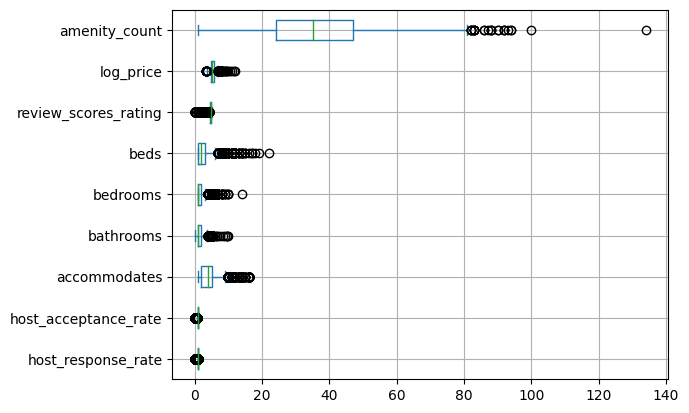

In [42]:
df6[[#'host_since', 
    'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    'accommodates', 'bathrooms', 'bedrooms', 'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     'log_price',
       'amenity_count']].plot.box(vert = False, grid = True);

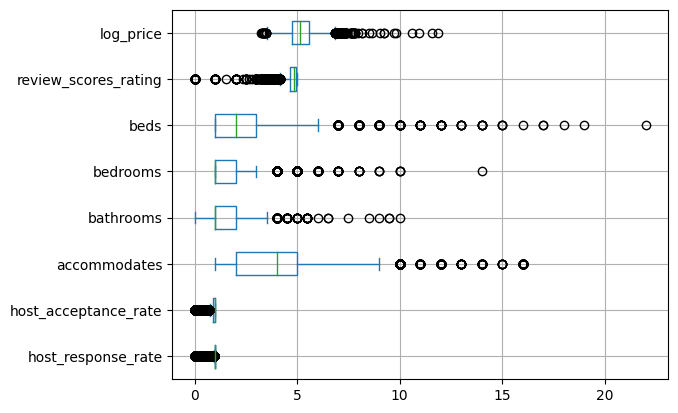

In [43]:
df6[[#'host_since', 
    'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    'accommodates', 'bathrooms', 'bedrooms', 'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     'log_price',
       #'amenity_count'
]].plot.box(vert = False, grid = True);

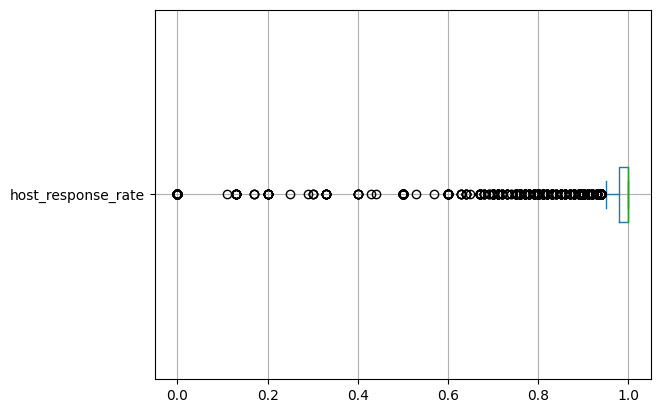

In [44]:
df6[[#'host_since', 
    'host_response_rate', #'host_acceptance_rate', #'host_listings_count', 
    #'accommodates', 'bathrooms', 'bedrooms', 'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
      # 'property_type', 'neighbourhood_cleansed', 
     #'log_price',
       #'amenity_count'
]].plot.box(vert = False, grid = True);

In [45]:
df6.loc[df6.host_response_rate < 0.2].price.mean()

274.58762886597935

In [46]:
df6.loc[df6.host_response_rate >= 0.8].price.mean()

288.38237072875717

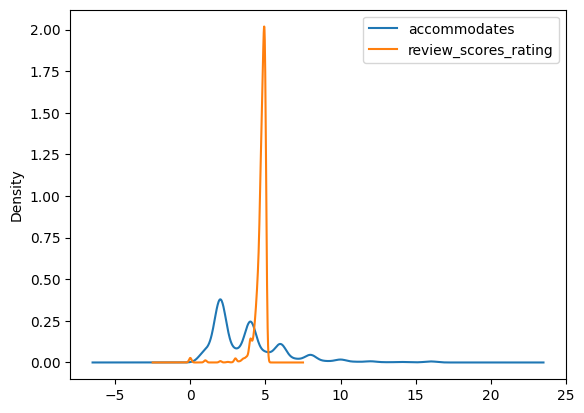

In [47]:
df6[[#'host_since', 
    #'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    'accommodates', #'bathrooms', 'bedrooms', 'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price',
       #'amenity_count'
]].plot.density();

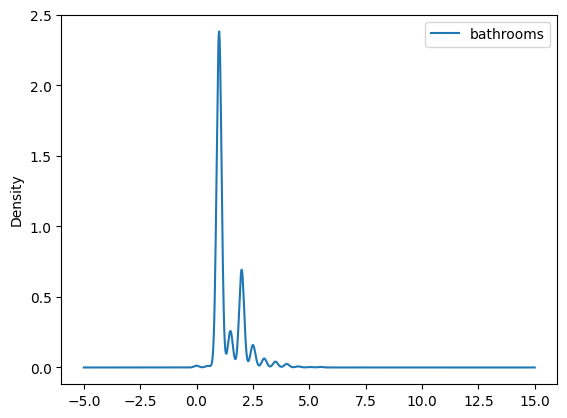

In [48]:
df6[[#'host_since', 
    #'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    #'accommodates', 
    'bathrooms', #'bedrooms', 'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price',
       #'amenity_count'
]].plot.density();

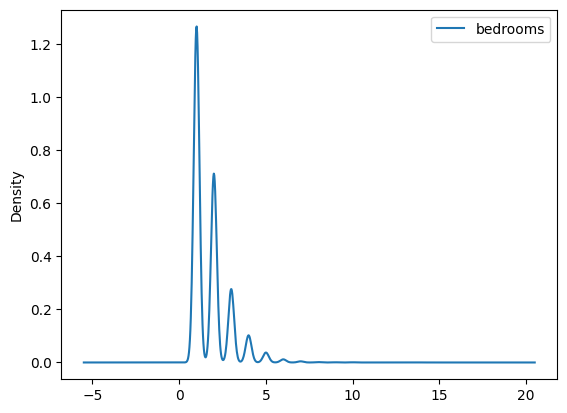

In [49]:
df6[[#'host_since', 
    #'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    #'accommodates', 
    #'bathrooms', 
    'bedrooms', #'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price',
       #'amenity_count'
]].plot.density();

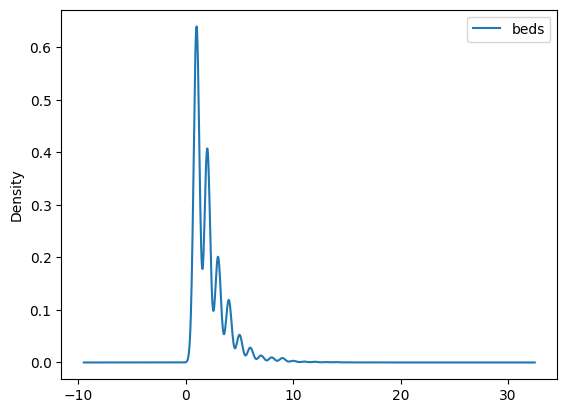

In [50]:
df6[[#'host_since', 
    #'host_response_rate', 'host_acceptance_rate', #'host_listings_count', 
    #'accommodates', 
    #'bathrooms', 
    #'bedrooms', 
    'beds', #'minimum_nights',
       #'maximum_nights', 
    #'availability_30', 'availability_60', 'availability_90', 'availability_365', 
     #'review_scores_rating', #'price',
       #'email', 'phone', 'work_email', 'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t',
       #'property_type', 'neighbourhood_cleansed', 
     #'log_price',
       #'amenity_count'
]].plot.density();

#### Bivariate EDA

##### Correlation Matrix

In [51]:
df6.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_roo

In [52]:
corr = df6[['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60',
       #'availability_90', 'availability_365', 
       'number_of_reviews', #'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', #'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       #'review_scores_communication', 'review_scores_location', 'review_scores_value', 'email', 'phone', 'work_email',
       'amenity_count', #'smoke_alarm', 'kitchen', 'essentials', 'hangers', 'wifi', 'host_is_superhost_t', 'host_has_profile_pic_t',
       #'host_identity_verified_t', 'has_availability_t', 'instant_bookable_t', 
        'review_scores_rating_scaled', 'review_scores_location_scaled',
       'review_scores_value_scaled', 'bath_bed_ratio', 'bath_guests_ratio',
       'bedrooms_guests_ratio', 'beds_guests_ratio', 'bedrooms_beds_ratio',
       'maxnights_minnights_ratio',
       #'price', 
            'log_price']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_34691/1021454963.py:15: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,number_of_reviews,review_scores_rating,amenity_count,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,log_price
host_since,1.00,0.09,0.02,-0.08,-0.04,-0.05,-0.02,-0.01,-0.01,-0.00,0.05,0.06,-0.16,-0.16,0.17,0.10,0.06,-0.14,-0.15,-0.14,-0.01,-0.00,-0.00,-0.01,0.01,-0.08,-0.02
host_response_time,0.09,1.00,-0.59,-0.55,0.03,0.13,-0.07,0.03,-0.03,-0.05,0.04,-0.02,0.02,0.01,-0.13,-0.07,-0.17,-0.19,-0.19,-0.19,0.09,0.13,0.13,0.07,0.08,-0.06,-0.10
host_response_rate,0.02,-0.59,1.00,0.40,0.00,-0.13,0.07,0.02,0.05,0.06,-0.03,-0.01,-0.10,-0.08,0.10,0.16,0.20,0.13,0.12,0.12,-0.05,-0.06,-0.08,-0.03,-0.06,-0.05,0.03
host_acceptance_rate,-0.08,-0.55,0.40,1.00,-0.20,-0.21,0.12,-0.06,0.07,0.08,-0.04,0.03,-0.04,-0.03,0.19,0.09,0.25,0.25,0.25,0.25,-0.20,-0.26,-0.18,-0.11,-0.09,0.06,0.14
host_listings_count,-0.04,0.03,0.00,-0.20,1.00,0.01,-0.02,0.13,-0.02,-0.01,0.00,-0.02,0.09,0.12,-0.09,-0.10,-0.11,-0.06,-0.05,-0.06,0.21,0.24,0.04,0.03,-0.00,-0.05,-0.04
room_type,-0.05,0.13,-0.13,-0.21,0.01,1.00,-0.39,-0.10,-0.32,-0.29,-0.01,-0.04,0.02,0.00,-0.15,-0.10,-0.26,-0.19,-0.19,-0.18,0.36,0.44,0.39,0.27,0.15,0.05,-0.49
accommodates,-0.02,-0.07,0.07,0.12,-0.02,-0.39,1.00,0.58,0.87,0.88,-0.01,0.07,0.11,0.09,-0.02,0.03,0.25,0.01,0.01,0.01,-0.38,-0.42,-0.36,-0.09,-0.35,0.02,0.57
bathrooms,-0.01,0.03,0.02,-0.06,0.13,-0.10,0.58,1.00,0.65,0.56,-0.01,-0.01,0.10,0.09,-0.11,0.02,0.12,-0.07,-0.07,-0.07,0.32,0.28,0.02,0.07,-0.08,-0.07,0.39
bedrooms,-0.01,-0.03,0.05,0.07,-0.02,-0.32,0.87,0.65,1.00,0.84,-0.01,0.04,0.10,0.07,-0.08,0.02,0.22,-0.04,-0.04,-0.04,-0.43,-0.28,-0.02,0.07,-0.10,-0.05,0.56
beds,-0.00,-0.05,0.06,0.08,-0.01,-0.29,0.88,0.56,0.84,1.00,-0.01,0.07,0.10,0.07,-0.04,0.01,0.21,-0.04,-0.04,-0.04,-0.35,-0.30,-0.19,0.26,-0.52,0.02,0.50


##### Interpretation
`host_since, host_response_time, host_response_rate, host_acceptance_rate, and host_listings_count`\
do not seem related to any other variables. Likely that they should be dropped.\
<br>
`Room Type`\
negative correlation of -0.49 with log price --> larger rooms are encoded with smaller integers. Hence correlation indicates that large / more private room types correlate with higher prices. Interestingly the relationship becomes irrelevant for non-log prices.\
<br>
`accommodates, bathrooms, bedrooms, beds`\
very strong correlation. This has to be analysed further to avoid multicollinearity down the line. accommodates and bedrooms have strongest positive correlation with log price out of those four.\
<br>
`minimum_nights and maximum_nights`\
do not seem related to any other variables. Likely that they should be dropped.\
<br>
`availability_30, availability_60, availability_90, and availability_365`\
There seems to be some relation with log price. Out of those, availability_30 seems to have strongest relation. Others should likely be dropped due to multicollinearity.\
<br>
`review_scores_rating, email, phone, work_email, smoke_alarm, kitchen, essentials, hangers, wifi, host_is_superhost_t, host_has_profile_pic_t, host_identity_verified_t, and has_availability_t`\
These seem all unrelated to both log price and price.\
<br>
`instant_bookable_t, property_type, neighbourhood_cleansed, and sum_amenities`\
These seem to have weak but existent relationship with log prices. instant_bookable and sum_amenities are positively related while property_type and neighbourhood_cleansed have a negative relationship. Thus, for property types the same logic applies as for room types and they might capture similar information. In the case of neighbourhood_cleansed it implies that the more listings exist in a suburb in the data, the higher its prices seem to be. Even though this is probably a weak relationship, but due to the construction of the neighbourhood encoding it seems to be the case. Further analysis is required with respect to individual suburbs as predictors of price.

NOTE: All correlations of prices with categorical data should be taken cautiously as the pearson correlation coefficient might not be suitable for those variables.

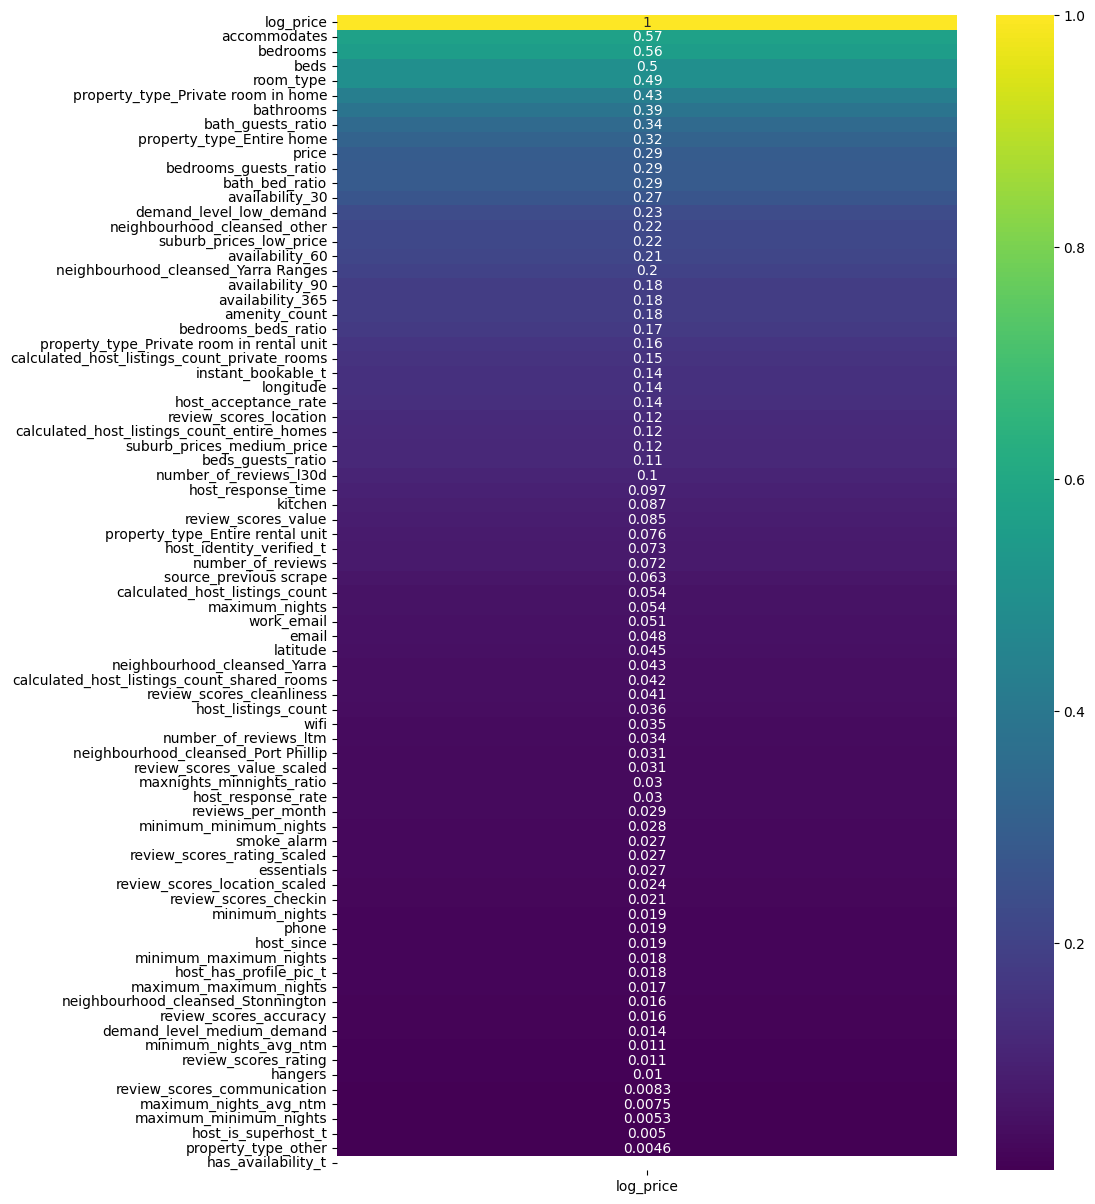

In [53]:
plt.figure(figsize=(10, 15))
# Plotting the heatmap with respect to the correlation of the features with the target variable
sns.heatmap(df6.corr()[['log_price']].abs().sort_values(by='log_price', ascending=False), annot=True, cmap='viridis');

##### Price vs Room Type

In [54]:
df6.groupby('room_type').price.mean()

room_type
0    309.685575
1    357.200000
2    189.223116
3    146.342857
Name: price, dtype: float64

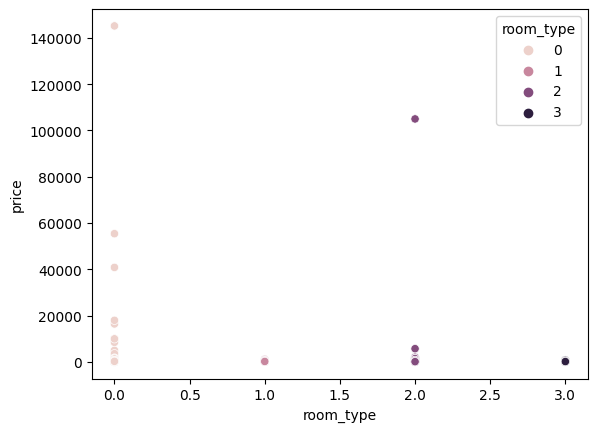

In [55]:
sns.scatterplot(x="room_type", y="price", data=df6, hue="room_type");

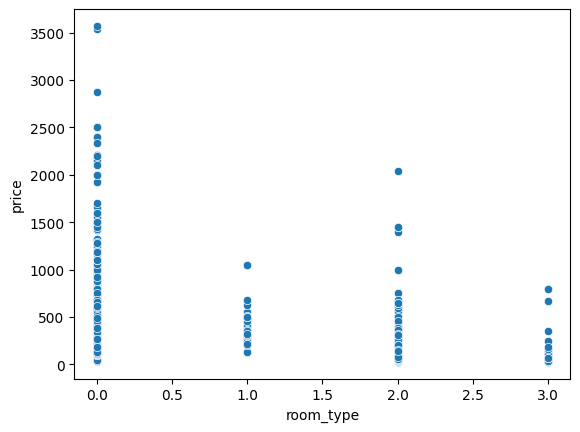

In [56]:
sns.scatterplot(x="room_type", y="price", data=df6.loc[df6.price < 5000]);

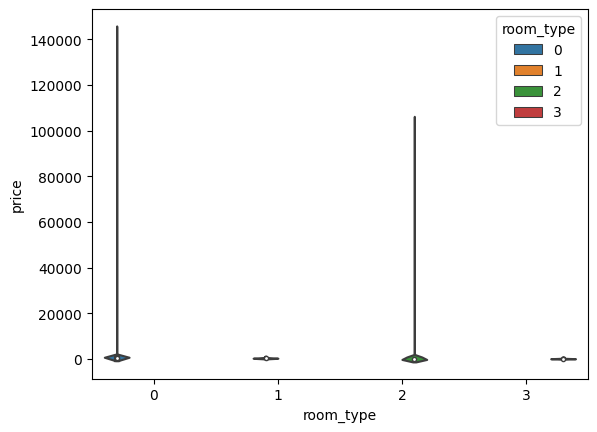

In [57]:
sns.violinplot(x="room_type", y="price", data=df6, hue="room_type");

In [58]:
df6.room_type.value_counts()

0    7860
2    2019
3      71
1      50
Name: room_type, dtype: int64

In [59]:
train = df6.iloc[0:7000,]
test = df6.iloc[7000:,]

In [60]:
print(train.room_type.value_counts(normalize=True))
print(test.room_type.value_counts(normalize=True))

0    0.793286
2    0.195286
1    0.006429
3    0.005000
Name: room_type, dtype: float64
0    0.769000
2    0.217333
3    0.012000
1    0.001667
Name: room_type, dtype: float64


For room type 0 and 2 there seem to be a few outliers that skew the results of the mean prices in these groups. Also room types 1 and 3 are heavily underrepresented in the data across both training and test data.

##### Price vs accommodates

In [61]:
df6.groupby('accommodates').price.mean()

accommodates
1      81.649770
2     255.288161
3     298.315789
4     266.825483
5     297.169355
6     336.270042
7     357.195489
8     466.615132
9     466.913043
10    587.894737
11    446.200000
12    517.945455
13    412.272727
14    556.157895
15    674.333333
16    724.041667
Name: price, dtype: float64

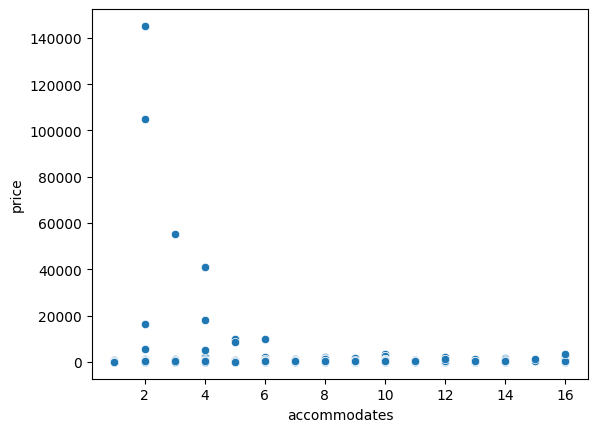

In [62]:
sns.scatterplot(x="accommodates", y="price", data=df6);

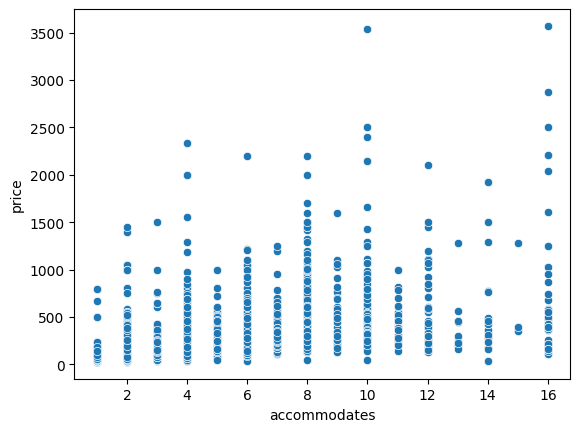

In [63]:
sns.scatterplot(x="accommodates", y="price", data=df6.loc[df6.price < 5000]);

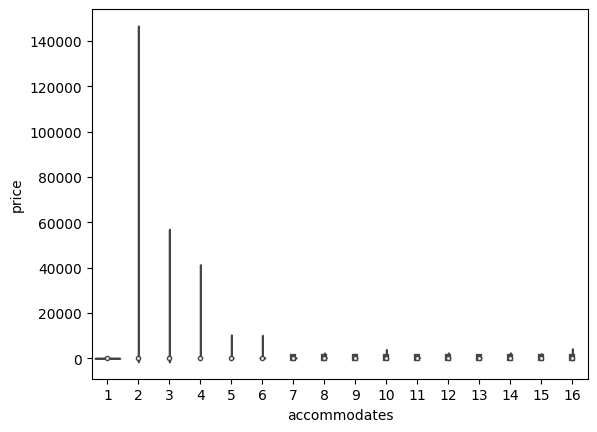

In [64]:
sns.violinplot(x="accommodates", y="price", data=df6);

In [65]:
df6.accommodates.value_counts(normalize=True)

2     0.3709
4     0.2390
6     0.1075
1     0.0639
3     0.0601
5     0.0511
8     0.0445
7     0.0174
10    0.0171
12    0.0069
9     0.0068
16    0.0062
11    0.0037
14    0.0030
13    0.0013
15    0.0006
Name: accommodates, dtype: float64

In [66]:
print(train.accommodates.value_counts(normalize=True))
print(test.accommodates.value_counts(normalize=True))

2     0.375286
4     0.236571
6     0.101571
3     0.062429
1     0.062000
5     0.053143
8     0.043429
7     0.019000
10    0.016286
12    0.007857
16    0.006857
9     0.006571
11    0.004286
14    0.002714
13    0.001571
15    0.000429
Name: accommodates, dtype: float64
2     0.360667
4     0.244667
6     0.121333
1     0.068333
3     0.054667
8     0.047000
5     0.046333
10    0.019000
7     0.013667
9     0.007333
16    0.004667
12    0.004667
14    0.003667
11    0.002333
15    0.001000
13    0.000667
Name: accommodates, dtype: float64


##### Price vs Bathrooms

In [67]:
df6.groupby('bathrooms').price.mean()

bathrooms
0.0      140.533333
0.5       83.800000
1.0      261.041396
1.5      178.167300
2.0      338.025457
2.5      388.352542
3.0      561.470000
3.5      647.694444
4.0      373.866667
4.5      553.500000
5.0     1032.000000
5.5      494.333333
6.0      564.000000
6.5      573.000000
7.5             NaN
8.5     3571.000000
9.0     2871.000000
9.5     2206.000000
10.0    2500.000000
Name: price, dtype: float64

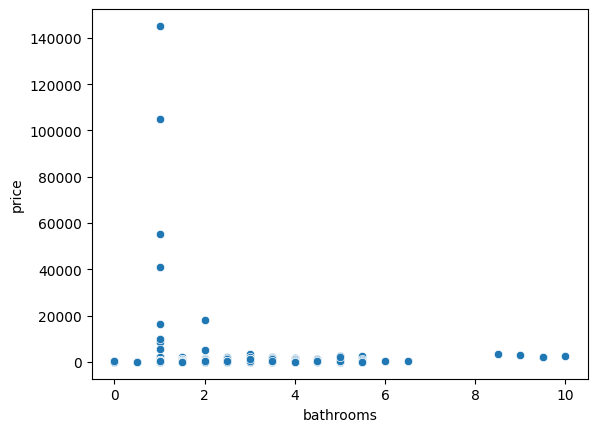

In [68]:
sns.scatterplot(x="bathrooms", y="price", data=df6);

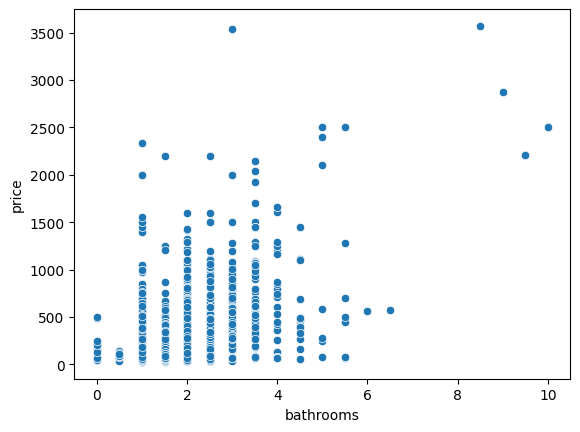

In [69]:
sns.scatterplot(x="bathrooms", y="price", data=df6.loc[df6.price < 5000]);

In [70]:
df6.loc[df6.price > 100000]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,source_previous scrape,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_low_price,suburb_prices_medium_price,log_price
3895,1668,3,1.0,0.886732,1.0,-37.79592,145.07212,2,2,1.0,1.0,1.0,70,1125,70.0,70,1125,1125.0,70.0,1125.0,30,60,90,365.0,5,0,0,5.00,5.00,5.0,5.00,5.00,4.80,5.00,1,0,1,0,0.11,104983.0,0.0,1.0,0.0,29,1,1,1,1,1,0.5500,0.5280,0.5500,1.000000,0.5,0.500000,0.5,1.00000,16.071429,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,11.561554
4170,2722,1,1.0,1.000000,4.0,-37.79781,144.96806,0,2,1.0,1.0,1.0,2,1125,2.0,2,1125,1125.0,2.0,1125.0,0,12,42,317.0,8,4,0,4.75,4.63,4.5,4.75,4.63,4.88,4.75,4,4,0,0,0.19,145160.0,1.0,1.0,0.0,24,1,1,1,1,1,0.9025,0.9272,0.9025,0.895176,0.5,0.505898,0.5,0.88285,562.500000,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11.885592


In [71]:
df6.bathrooms.value_counts(normalize=True)

1.0     0.6497
2.0     0.1891
1.5     0.0706
2.5     0.0435
3.0     0.0174
3.5     0.0113
4.0     0.0069
0.0     0.0034
0.5     0.0030
4.5     0.0021
5.5     0.0012
5.0     0.0009
9.5     0.0002
6.5     0.0002
6.0     0.0001
9.0     0.0001
10.0    0.0001
8.5     0.0001
7.5     0.0001
Name: bathrooms, dtype: float64

##### Price vs Bedrooms

In [72]:
df6.groupby('bedrooms').price.mean()

bedrooms
1.0      251.991150
2.0      252.505114
3.0      376.752896
4.0      488.214545
5.0      641.594340
6.0      562.710526
7.0      893.727273
8.0     1491.000000
9.0      554.666667
10.0    2427.666667
14.0     350.000000
Name: price, dtype: float64

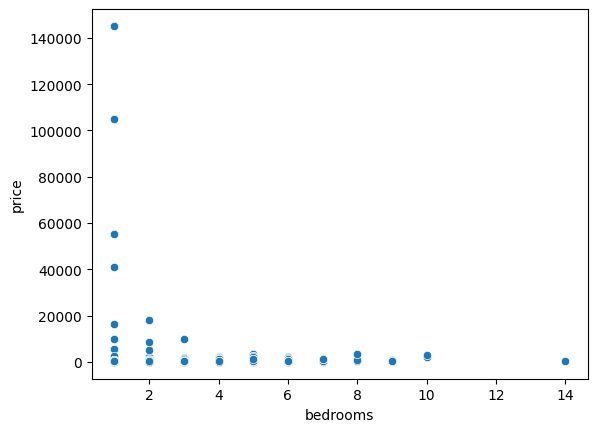

In [73]:
sns.scatterplot(x="bedrooms", y="price", data=df6);

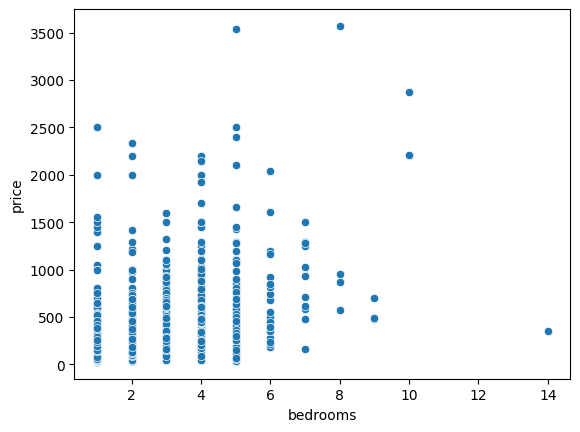

In [74]:
sns.scatterplot(x="bedrooms", y="price", data=df6.loc[df6.price < 5000]);

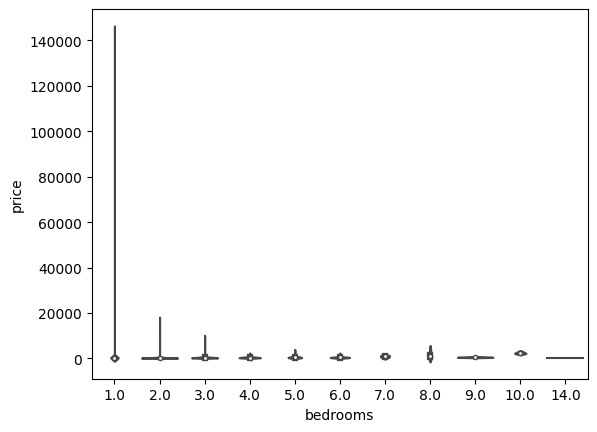

In [75]:
sns.violinplot(x="bedrooms", y="price", data=df6);

In [76]:
df6.bedrooms.value_counts(normalize=True)

1.0     0.5246
2.0     0.2948
3.0     0.1147
4.0     0.0424
5.0     0.0155
6.0     0.0049
7.0     0.0018
8.0     0.0006
9.0     0.0003
10.0    0.0003
14.0    0.0001
Name: bedrooms, dtype: float64

##### Price vs availability

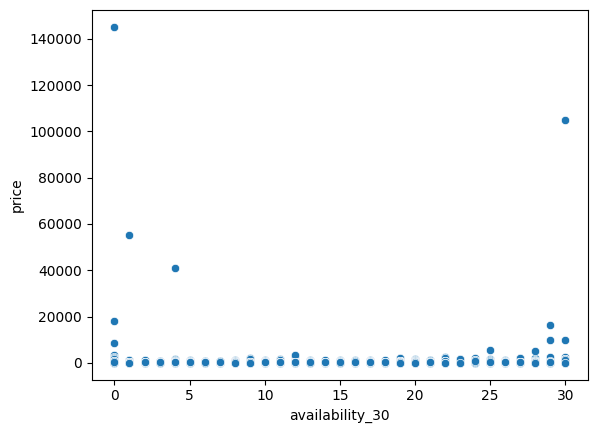

In [77]:
sns.scatterplot(x="availability_30", y="price", data=df6);

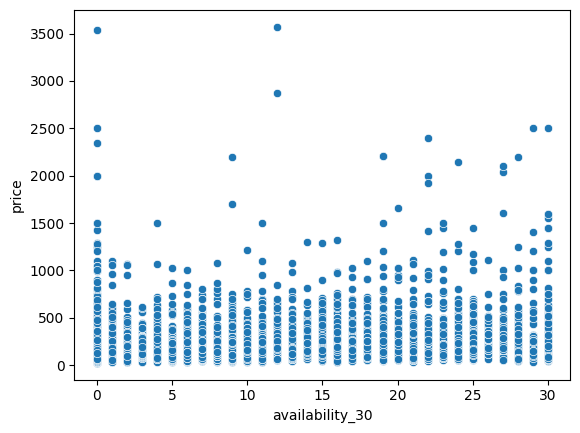

In [78]:
sns.scatterplot(x="availability_30", y="price", data=df6.loc[df6.price < 5000]);

##### Price vs sum_amenities

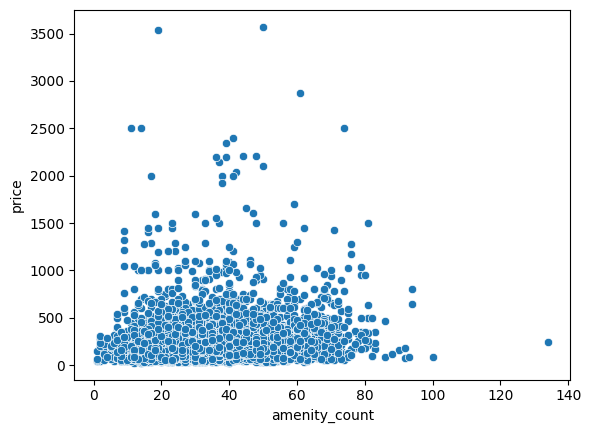

In [79]:
sns.scatterplot(x="amenity_count", y="price", data=df6.loc[df6.price < 5000]);

`host_since, host_response_time, host_response_rate, host_acceptance_rate, and host_listings_count`\
do not seem related to any other variables. Likely that they should be dropped.\
<br>

`Room Type`\
negative correlation of -0.49 with log price --> larger rooms are encoded with smaller integers. Hence correlation indicates that large / more private room types correlate with higher prices. Interestingly the relationship becomes irrelevant for non-log prices.\
<br>

`accommodates, bathrooms, bedrooms, beds`\
very strong correlation. This has to be analysed further to avoid multicollinearity down the line. accommodates and bedrooms have strongest positive correlation with log price out of those four.\
<br>

`minimum_nights and maximum_nights`\
do not seem related to any other variables. Likely that they should be dropped.\
<br>

`availability_30, availability_60, availability_90, and availability_365`\
There seems to be some relation with log price. Out of those, availability_30 seems to have strongest relation. Others should likely be dropped due to multicollinearity.\
<br>

`review_scores_rating, email, phone, work_email, smoke_alarm, kitchen, essentials, hangers, wifi, host_is_superhost_t, host_has_profile_pic_t, host_identity_verified_t, and has_availability_t`\
These seem all unrelated to both log price and price.\
<br>

`instant_bookable_t, property_type, neighbourhood_cleansed, and sum_amenities`\
These seem to have weak but existent relationship with log prices. instant_bookable and sum_amenities are positively related while property_type and neighbourhood_cleansed have a negative relationship. Thus, for property types the same logic applies as for room types and they might capture similar information. In the case of neighbourhood_cleansed it implies that the more listings exist in a suburb in the data, the higher its prices seem to be. Even though this is probably a weak relationship, but due to the construction of the neighbourhood encoding it seems to be the case. Further analysis is required with respect to individual suburbs as predictors of price.

NOTE: All correlations of prices with categorical data should be taken cautiously as the pearson correlation coefficient might not be suitable for those variables.

All other variables that were deemed relevant have been plotted against price. For many there does not seem to exist a clear relationship except for the ones outlined above where correlation was visible.

--- 
## Fit and tune a forecasting model

In [10]:
def get_params(model, features, X_train, y_train, param_grid):
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    # Calculate feature importance
    importances = grid_search.best_estimator_.feature_importances_
    feature_names = features
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance['Rank'] = feature_importance['Importance'].rank(ascending=False)
    feature_importance = feature_importance.sort_values(by='Rank')
    
    return best_score, best_params, feature_importance

def model_fit_pred(model, X_train, y_train, X_test, params):

    # Create pipeline with standard scaler and model
    pipe = make_pipeline(StandardScaler(), model(random_state=42, **params))
    
    # Perform cross-validation and calculate average RMSE
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    average_rmse = np.mean(rmse_scores) *100

    # Fit the pipeline to training data
    pipe.fit(X_train, y_train)
    
    # Make predictions on training data
    y_pred = pipe.predict(X_train)
    y_pred_dollar = np.round(np.exp(y_pred))
    
    y_train_dollar = np.round(np.exp(y_train))
    
    # Calculate RMSE on training data
    rmse = np.sqrt(mean_squared_error(y_train_dollar, y_pred_dollar))
    
    # Make predictions on test data
    y_pred = pipe.predict(X_test)
    y_pred_dollar = np.round(np.exp(y_pred))
        
    return average_rmse, rmse, y_pred_dollarllar


In [27]:
# find and remove outliers

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_outliers(data, threshold=3):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    z_scores = scaled_data.flatten()
    outlier_locations = np.where(np.abs(z_scores) > threshold)[0]
    outlier_values = data[outlier_locations]
    outlier_df = pd.DataFrame({'Outlier': outlier_values})
    return outlier_df



In [28]:
df6

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,source_previous scrape,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_low_price,suburb_prices_medium_price,log_price
0,3729,1,1.000000,0.980000,2.0,-37.82030,144.99016,0,2,1.0,1.0,1.0,2,14,2.0,2,1125,1125.0,2.0,1125.0,0,0,0,12.0,741,37,1,4.880000,4.910000,4.970000,4.940000,4.93000,4.930000,4.820000,2,2,0,0,6.110000,132.0,1.0,1.0,0.0,38,1,0,1,1,1,29.816800,30.12230,29.450200,1.000000,0.50000,0.500,0.500000,1.000000,7.00,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4.882802
1,5006,2,1.000000,0.980000,1.0,-37.76606,144.97951,2,2,1.0,1.0,1.0,4,27,4.0,4,27,27.0,4.0,27.0,0,12,22,112.0,169,25,3,4.480000,4.640000,3.970000,4.720000,4.69000,4.650000,4.600000,1,0,1,0,1.370000,39.0,1.0,1.0,0.0,57,1,1,1,1,0,6.137600,6.37050,6.302000,1.000000,0.50000,0.500,0.500000,1.000000,6.75,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,3.663562
2,4203,2,1.000000,0.780000,2.0,-37.90546,145.39447,0,4,2.5,2.0,4.0,2,365,2.0,2,365,365.0,2.0,365.0,30,60,90,365.0,8,2,0,4.750000,4.880000,4.750000,4.880000,4.50000,5.000000,4.750000,2,2,0,0,0.090000,270.0,1.0,1.0,0.0,21,1,1,0,0,1,0.427500,0.45000,0.427500,1.250000,0.62500,0.500,1.000000,0.500000,182.50,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,5.598422
3,4736,3,0.750000,0.920000,4.0,-37.82163,144.96672,2,2,2.5,1.0,1.0,1,730,1.0,1,730,730.0,1.0,730.0,30,60,90,365.0,2,0,0,4.500000,4.000000,4.500000,4.000000,4.00000,5.000000,4.000000,1,0,1,0,0.010000,1000.0,1.0,1.0,0.0,13,0,1,0,0,1,0.045000,0.05000,0.040000,2.500000,1.25000,0.500,0.500000,1.000000,730.00,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,6.907755
4,4707,2,1.000000,0.870000,1.0,-38.05725,145.33936,0,5,1.0,3.0,3.0,1,14,1.0,1,14,14.0,1.0,14.0,17,21,51,312.0,214,39,4,4.860000,4.910000,4.980000,4.910000,4.93000,4.900000,4.870000,1,1,0,0,1.430000,116.0,1.0,1.0,1.0,49,1,1,1,1,1,6.949800,7.00700,6.964100,0.333333,0.20000,0.600,0.600000,1.000000,14.00,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4.753590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3223,1,0.959781,0.886732,1.0,-37.82025,145.03088,2,2,1.0,1.0,1.0,1,1125,1.0,1,1125,1125.0,1.0,1125.0,0,0,0,0.0,2,0,0,4.500000,4.000000,5.000000,5.000000,5.00000,4.500000,4.500000,1,0,1,0,0.020000,NaN,1.0,1.0,0.0,13,1,1,1,1,1,0.090000,0.09000,0.090000,1.000000,0.5

In [86]:
## Model 1

## RandomForestRegressor 

df_train = df6[:7000]

price_outlier = get_outliers(df_train['price'])
    
df_test = df6[7000:]
    
columns_to_drop = ['price', 'log_price']

features = df_train.drop(columns=columns_to_drop).columns

y_train = df_train['log_price'].values

X_train = df_train.drop(columns=columns_to_drop).values

model = RandomForestRegressor
model_param = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100,200,500,700],
    'max_depth': [None,2,5,10,20],
    'min_samples_split': [2,5,10]
}

best_score, best_params, feature_importance = get_params(model_param, features, X_train, y_train, param_grid)

print('Best Params:', best_params, '\n')

n_features = 10
feature_selection  = feature_importance['Feature'].head(n_features).values 

print('Feature Selection:', feature_selection, '\n')

X_train = df_train[feature_selection].values

X_test =  df_test[feature_selection].values

average_rmse, rmse, y_pred_dollar = model_fit_pred(model, X_train, y_train, X_test, best_params)
    
print('Average RMSE:', average_rmse, '\n')
print('RMSE:', rmse)

pred = pd.DataFrame({"ID":test_id, "price": np.exp(y_pred)})
pred.to_csv("pricepredictions.csv", index=False, header=True)
pred.head(5)


KeyboardInterrupt: 

In [ ]:
## Model 2

## RandomForestRegressor - Outliers removed

df_train = df6[:7000]

price_outlier = get_outliers(df_train['price'])
df_train = df_train[~df_train['price'].isin(price_outlier['Outlier'].values)]
df_train.reset_index(drop=True, inplace=True)
    
df_test = df6[7000:]
    
columns_to_drop = ['price', 'log_price']

features = df_train.drop(columns=columns_to_drop).columns

y_train = df_train['log_price'].values

X_train = df_train.drop(columns=columns_to_drop).values

model = RandomForestRegressor
model_param = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100,200,500,700],
    'max_depth': [None,2,5,10,20],
    'min_samples_split': [2,5,10]
}

best_score, best_params, feature_importance = get_params(model_param, features, X_train, y_train, param_grid)

print('Best Params:', best_params, '\n')

n_features = 10
feature_selection  = feature_importance['Feature'].head(n_features).values 

print('Feature Selection:', feature_selection, '\n')

X_train = df_train[feature_selection].values

X_test =  df_test[feature_selection].values

average_rmse, rmse, y_pred_dollar = model_fit_pred(model, X_train, y_train, X_test, best_params)
    
print('Average RMSE:', average_rmse, '\n')
print('RMSE:', rmse)

pred = pd.DataFrame({"ID":test_id, "price": np.exp(y_pred)})
pred.to_csv("pricepredictions.csv", index=False, header=True)
pred.head(5)


In [ ]:
## Model 3

## GradientBoostRegressor 

df_train = df6[:7000]

price_outlier = get_outliers(df_train['price'])
    
df_test = df6[7000:]
    
columns_to_drop = ['price', 'log_price']

features = df_train.drop(columns=columns_to_drop).columns

y_train = df_train['log_price'].values

X_train = df_train.drop(columns=columns_to_drop).values

model = GradientBoostRegressor
model_param = GradientBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [100,200,500,700],
    'max_depth': [None,2,5,10,20],
    'min_samples_split': [2,5,10]
}

best_score, best_params, feature_importance = get_params(model_param, features, X_train, y_train, param_grid)

print('Best Params:', best_params, '\n')

n_features = 10
feature_selection  = feature_importance['Feature'].head(n_features).values 

print('Feature Selection:', feature_selection, '\n')

X_train = df_train[feature_selection].values

X_test =  df_test[feature_selection].values

average_rmse, rmse, y_pred_dollar = model_fit_pred(model, X_train, y_train, X_test, best_params)
    
print('Average RMSE:', average_rmse, '\n')
print('RMSE:', rmse)

pred = pd.DataFrame({"ID":test_id, "price": np.exp(y_pred)})
pred.to_csv("pricepredictions.csv", index=False, header=True)
pred.head(5)

In [ ]:
## Model 4

## GradientBoostRegressorForestRegressor - Outliers removed

df_train = df6[:7000]

price_outlier = get_outliers(df_train['price'])
df_train = df_train[~df_train['price'].isin(price_outlier['Outlier'].values)]
df_train.reset_index(drop=True, inplace=True)
    
df_test = df6[7000:]
    
columns_to_drop = ['price', 'log_price']

features = df_train.drop(columns=columns_to_drop).columns

y_train = df_train['log_price'].values

X_train = df_train.drop(columns=columns_to_drop).values

model = GradientBoostRegressor
model_param = GradientBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [100,200,500,700],
    'max_depth': [None,2,5,10,20],
    'min_samples_split': [2,5,10]
}

best_score, best_params, feature_importance = get_params(model_param, features, X_train, y_train, param_grid)

print('Best Params:', best_params, '\n')

n_features = 10
feature_selection  = feature_importance['Feature'].head(n_features).values 

print('Feature Selection:', feature_selection, '\n')

X_train = df_train[feature_selection].values

X_test =  df_test[feature_selection].values

average_rmse, rmse, y_pred_dollar = model_fit_pred(model, X_train, y_train, X_test, best_params)
    
print('Average RMSE:', average_rmse, '\n')
print('RMSE:', rmse)

pred = pd.DataFrame({"ID":test_id, "price": np.exp(y_pred)})
pred.to_csv("pricepredictions.csv", index=False, header=True)
pred.head(5)


In [80]:
# RandomForestRegressor FINAL AND BEST MODEL
    
#df6  = pd.read_csv('df_6.csv')
    
df_train = df6[:7000]

#df_train = df_train[df_train['price'] < 3001]

#price_outlier = get_outliers(df_train['price'])
#df_train = df_train[~df_train['price'].isin(price_outlier['Outlier'].values)]
#df_train.reset_index(drop=True, inplace=True)
    
    
df_test = df6[7000:]
    
columns_to_drop = [    
  
'price'
,'log_price'
    
#,'property_type_Private room in home'
#,'availability_30'
    
,'calculated_host_listings_count_entire_homes'
,'calculated_host_listings_count_shared_rooms'
    
#,'maximum_nights_avg_ntm'
#,'instant_bookable_t'
#,'maximum_maximum_nights'
#,'number_of_reviews_l30d'
#,'minimum_minimum_nights'
 #,'neighbourhood_cleansed_other'
 #,'room_type'
    
 #'bathrooms',
 #'bedrooms',
 #'calculated_host_listings_count_private_rooms',
 #'accommodates'
  ,'review_scores_location_scaled',
 'bath_bed_ratio',
 'beds_guests_ratio',
 'maxnights_minnights_ratio',
 'bath_guests_ratio',
 'bedrooms_guests_ratio',
 'demand_level_medium_demand',
 'review_scores_value_scaled',
 'demand_level_low_demand',
 'bedrooms_beds_ratio',
 'review_scores_rating_scaled'
    
,'review_scores_location'
,'calculated_host_listings_count'
    
,'property_type_Entire home'
,'maximum_minimum_nights'
,'smoke_alarm'
,'review_scores_rating'
,'property_type_other'
,'minimum_nights'
,'availability_365'
,'number_of_reviews_ltm'
,'availability_60'
,'source_previous scrape'
,'review_scores_communication'
,'review_scores_value'
,'review_scores_cleanliness'
,'availability_90'
,'neighbourhood_cleansed_Port Phillip'
,'reviews_per_month'
,'longitude'
,'minimum_maximum_nights'
,'host_acceptance_rate'
,'neighbourhood_cleansed_Yarra Ranges'
,'minimum_nights_avg_ntm'
,'maximum_nights'
,'email'
,'amenity_count'
,'host_response_rate'
,'review_scores_accuracy'
,'number_of_reviews'
,'host_listings_count'
,'review_scores_checkin'
,'neighbourhood_cleansed_Yarra'
,'neighbourhood_cleansed_Stonnington'
,'beds'
,'property_type_Entire rental unit'
,'work_email'
,'latitude'
,'hangers'
,'host_since'
,'host_is_superhost_t'
,'kitchen'
,'wifi'
,'property_type_Private room in rental unit'
,'host_response_time'
,'host_has_profile_pic_t'
,'essentials'
,'host_identity_verified_t'
,'phone'
,'has_availability_t'
,'suburb_prices_low_price'
,'suburb_prices_medium_price',
    
    
]
    
    
    
    
y_train = df_train['log_price'].values
    
X_train = df_train.drop(columns=columns_to_drop).values
    
X_test =  df_test.drop(columns=columns_to_drop).values
  
    
    
    
param_grid = {
    'n_estimators': [100, 200, 300,400,500,600,700,800],  # Number of boosting stages to perform
#    'learning_rate': [0.1, 0.05, 0.01],  # Learning rate shrinks the contribution of each tree
    'min_samples_split': [2, 5, 10,20,50],
    'max_depth': [3, 4, 5, 10, 15, 20, 25, 30,50 ]  # Maximum depth of each decision tree
}
    
#gb_model = RandomForestRegressor(random_state=42)
    
#grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs = 24)
    
#grid_search.fit(X_train, y_train)
#best_params = grid_search.best_params_
#print(best_params)
    
#pipe = make_pipeline(StandardScaler(),
#                    RandomForestRegressor(random_state=42, **best_params))
    
#pipe = make_pipeline(StandardScaler(),
#                     RandomForestRegressor(random_state=42, n_estimators=100 , max_depth=700, min_samples_split=50))
    
#pipe = make_pipeline(StandardScaler(),
#                     RandomForestRegressor(random_state=42, n_estimators=100 , max_depth=700, min_samples_split=20,
#                                          n_jobs=-1 ))
# n_estimators=10
    
#pipe = make_pipeline(StandardScaler(),
#                     RandomForestRegressor(random_state=42, n_estimators=100 , max_depth=1700,max_features=1,
#                                          bootstrap=False,criterion='squared_error',
#                                          n_jobs=-1
#                                          ))
    
pipe = make_pipeline(StandardScaler(),
                     RandomForestRegressor(random_state=42, n_estimators=10 , max_depth=700))
          
    
#{'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 700}    
    
    
x = pipe.fit(X_train, y_train)
pipe.fit(X_train, y_train)
    
y_pred = pipe.predict(X_train)
y_pred_dollar = np.round(np.exp(y_pred))
    
y_train_dollar = np.round(np.exp(y_train))
    
    
    
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
rmse_scores = np.sqrt(-cv_scores)
# Print the RMSE scores for each fold
for i, rmse in enumerate(rmse_scores):
    print("Fold {}: RMSE = {:.4f}".format(i+1, rmse))
    
# Calculate and print the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(average_rmse*100))
    
    
    
rmse = np.sqrt(mean_squared_error(y_train_dollar, y_pred_dollar))
print(f'Root Mean Squared Error: {rmse}')
    
train_pred = pd.DataFrame({"price":y_train_dollar, "pred":y_pred_dollar})
train_pred.head(5)
    
    
#df_test = pd.read_csv(\"test.csv\")
#X_test = df_test.drop(['ID'], axis=1).values
y_pred = pipe.predict(X_test)
y_pred_dollar = np.round(np.exp(y_pred))
    
#test_pred = pd.DataFrame({"price":y_test_dollar, "pred":y_test_pred_dollar})
#test_pred.head(100)
    
    
test_id = np.arange(7000, 10000, 1)
pred = pd.DataFrame({"ID":test_id, "price": np.exp(y_pred)})
pred.to_csv("pricepredictions10.csv", index=False, header=True)
pred.head(5)

Fold 1: RMSE = 0.4609
Fold 2: RMSE = 0.4650
Fold 3: RMSE = 0.5508
Fold 4: RMSE = 0.4733
Fold 5: RMSE = 0.4824
Average RMSE: 48.6500
Root Mean Squared Error: 2238.1403217850307


,ID,price
0,7000,203.609721
1,7001,156.940156
2,7002,70.767527
3,7003,181.066538
4,7004,210.815451


We attempted to train several regression models, including RandomForestRegressor, GradientBoostRegressor, LASSO, and elastic net, with hyperparameter tuning using GridSearchCV. The top 10 features, as determined by their importance in the regression model, were selected for training.

RandomForestRegressor performed the best based on the Root Mean Squared Error (RMSE) and cross-validation (CV) scores. However evaluating the models on unseen data it was observed that they did not generalise well, even though the RMSE and CV scores appeared reasonable. This discrepancy indicated that the models were overfitting the training set.

To address this issue, we removed price outliers from the dataset and retrained the models. However, even after this preprocessing step, the models performed poorly on the test data, suggesting that some of the outliers were present in the test set. This was evident from the very low RMSE score, indicating a high level of overfitting.

We then experimented with different combinations of features to train the models. Although there was some improvement in the RMSE and CV scores, the models still failed to significantly improve the test scores. To refine the feature selection process, we relied on the rankings provided by XGBoost and eliminated the features that had little impact on the price prediction. Additionally, we made some hyperparameter changes, such as reducing the number of estimators and increasing the depth of the RandomForestRegressor.

Through these adjustments, we were able to achieve a test score of 3409.51 using RandomForestRegressor. Despite efforts to train and tune various regression models, we were not able to generalise the models to unseen data to achieving high accuracy in price prediction. Further refinement of model and feature selection and hyperparameters may be necessary to enhance the model's performance.